In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import os

In [2]:
import skimage
from skimage.transform import resize

In [3]:
imageSize = 224
target_dims = (imageSize, imageSize, 3)
num_classes = 29

train_len = 50
train_dir = r'C:/Users/vatsa/OneDrive/Desktop/Covid-19-X-Ray-Recognition/dataset/'

def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = np.empty((train_len, imageSize, imageSize, 3), dtype=np.float32)
    y = np.empty((train_len,), dtype=np.int)
    cnt = 0

    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['normal']:
                label = 0
            elif folderName in ['covid']:
                label = 1
                
            for image_filename in os.listdir(folder + folderName):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file).reshape((-1, imageSize, imageSize, 3))
                    
                    X[cnt] = img_arr
                    y[cnt] = label
                    cnt += 1
#                     X.append(img_arr)
#                     y.append(label)
#     X = np.asarray(X)
#     y = np.asarray(y)
    return X,y
X_data, y_data = get_data(train_dir)

In [4]:
X_data.shape

(50, 224, 224, 3)

In [5]:
y_data.shape

(50,)

In [12]:
from keras.utils import to_categorical

In [7]:
Y_data = to_categorical(y_data)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3,
                                                    stratify=Y_data, random_state=42)

In [10]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(35, 224, 224, 3) (15, 224, 224, 3)
(35, 2) (15, 2)


In [11]:
del X_data, y_data, Y_data

### Creating The Model

In [13]:
from keras.layers import Convolution2D, Dense, Dropout, Flatten, Activation, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
BS = 8

In [17]:
model = Sequential()

model.add(Convolution2D(32, (5, 5), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Convolution2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(2, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
activation_5 (Activation)    (None, 220, 220, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
activation_6 (Activation)    (None, 108, 108, 64)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 64)       

In [18]:
from keras.layers import Conv2D, MaxPool2D

In [20]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
from keras.preprocessing.image import ImageDataGenerator

In [22]:
trainAug = ImageDataGenerator(rotation_range=15,
                              fill_mode="nearest")

In [23]:
testAug = ImageDataGenerator(rotation_range=10,
                              fill_mode="nearest")

In [24]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [26]:
model.fit_generator(trainAug.flow(X_train, y_train, batch_size=BS, shuffle=True),
                    steps_per_epoch=len(X_train)//BS,
                    validation_data=testAug.flow(X_test, y_test, batch_size=BS, shuffle=False),
                    validation_steps=len(X_test)//BS,
                    epochs=7,
                    verbose=2,
                    callbacks=[early_stop])

Epoch 1/7
 - 0s - loss: 0.4707 - acc: 0.8380 - val_loss: 0.1588 - val_acc: 0.8750
Epoch 2/7
 - 0s - loss: 0.1707 - acc: 0.9062 - val_loss: 0.5361 - val_acc: 0.8571
Epoch 3/7
 - 0s - loss: 0.4289 - acc: 0.8287 - val_loss: 0.0246 - val_acc: 1.0000
Epoch 4/7
 - 0s - loss: 0.2269 - acc: 0.9676 - val_loss: 0.0673 - val_acc: 1.0000
Epoch 5/7
 - 0s - loss: 0.1068 - acc: 0.9676 - val_loss: 0.0281 - val_acc: 1.0000


In [25]:
model.save('FinalModel.h5')

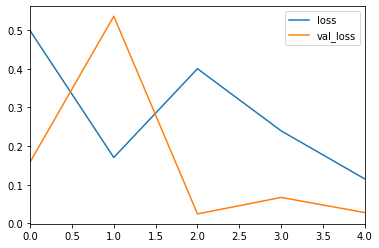

In [27]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [28]:
model.metrics_names

['loss', 'acc']

In [29]:
model.evaluate_generator(testAug.flow(X_test, y_test, batch_size=BS))

[0.13716047207514445, 0.9333333373069763]